In [1]:
#pip install seaborn

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
games_df = pd.read_csv('games.csv')
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


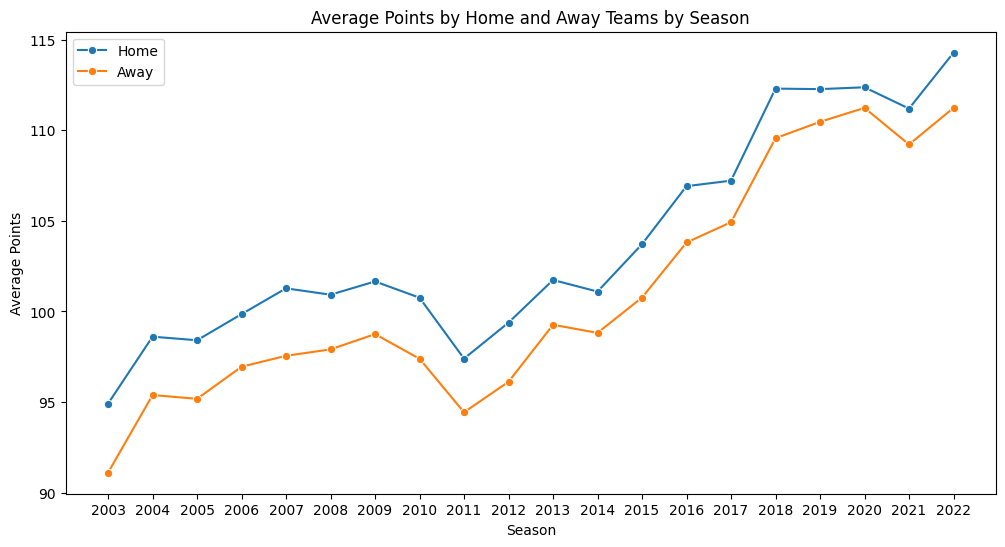

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the average points by home and away teams by season
avg_points_by_season = games_df.groupby('SEASON')[['PTS_home', 'PTS_away']].mean()

# Plot the average points by home and away teams by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_home', marker='o', label='Home')
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_away', marker='o', label='Away')
plt.title('Average Points by Home and Away Teams by Season')
plt.xlabel('Season')
plt.ylabel('Average Points')
plt.xticks(avg_points_by_season.index)  # Ensure x-axis ticks are integers
plt.legend()
plt.show()


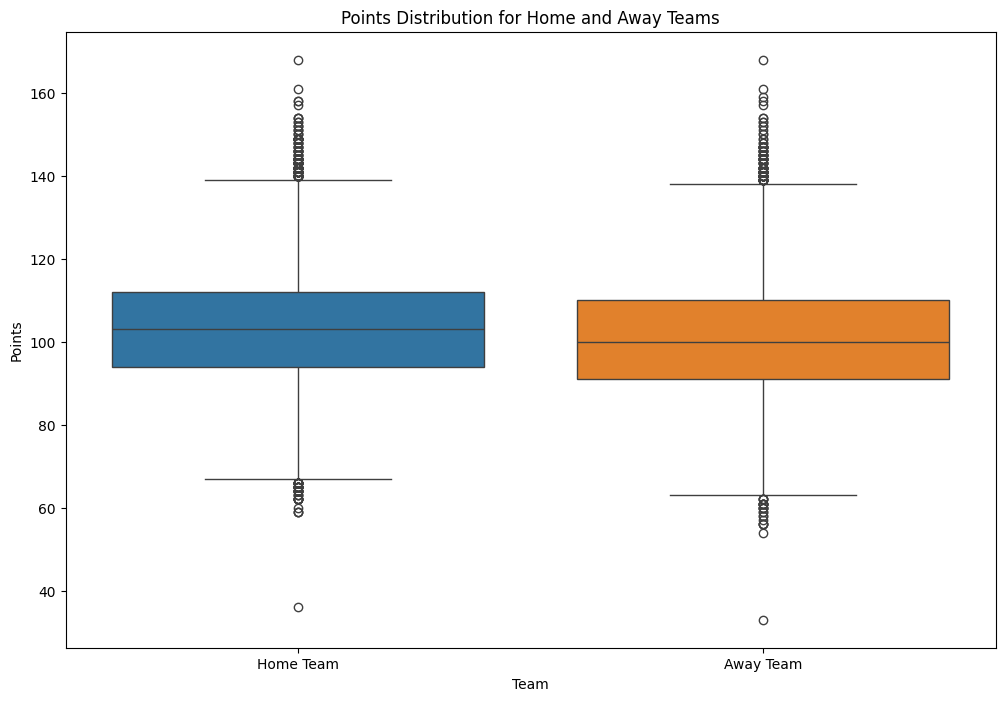

In [5]:
# Plot box plots of points distribution for home and away teams
plt.figure(figsize=(12, 8))
sns.boxplot(data=games_df[['PTS_home', 'PTS_away']])
plt.title('Points Distribution for Home and Away Teams')
plt.xlabel('Team')
plt.ylabel('Points')
plt.xticks([0, 1], ['Home Team', 'Away Team'])
plt.show()


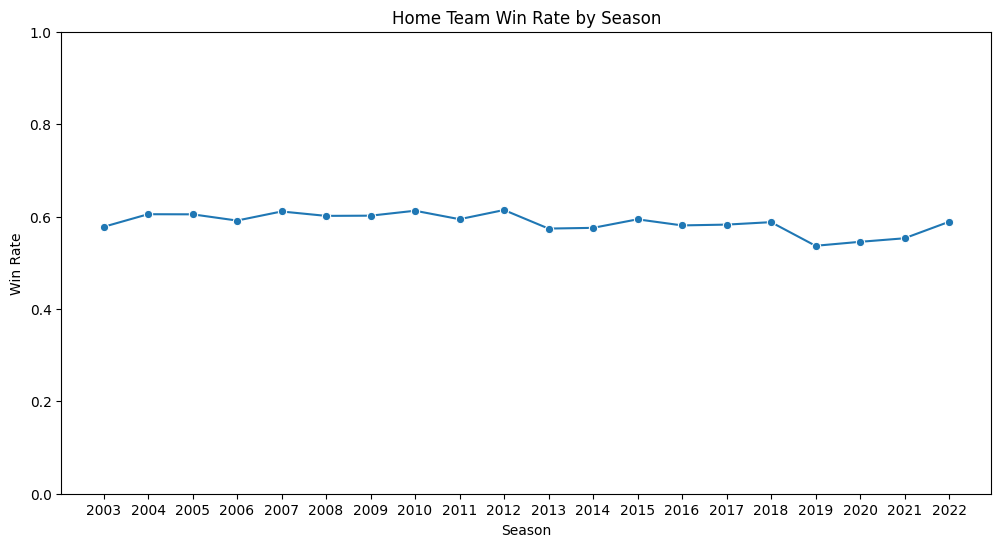

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the win rate by season
win_rate_by_season = games_df.groupby('SEASON')['HOME_TEAM_WINS'].mean()

# Plot the home team win rate by season
plt.figure(figsize=(12, 6))
sns.lineplot(x=win_rate_by_season.index, y=win_rate_by_season.values, marker='o')
plt.title('Home Team Win Rate by Season')
plt.xlabel('Season')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.xticks(win_rate_by_season.index)  # Ensure x-axis ticks are integers
plt.show()


In [7]:
details_df = pd.read_csv('games_details.csv')
details_df.head()

/var/folders/9h/lkfq_c4j39x2p116rk0qh8h40000gn/T/ipykernel_82242/1978113452.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details_df = pd.read_csv('games_details.csv')


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [8]:
#For space considerations, we drop all games prior to 2017
drop_ids = [] 
for index, row in games_df.iterrows():
    year_str = row['GAME_DATE_EST']
    year = int(year_str[0:4])
    if(year < 2017):
        drop_ids.append(row['GAME_ID'])

games_df = games_df[~games_df['GAME_ID'].isin(drop_ids)]
details_df = details_df[~details_df['GAME_ID'].isin(drop_ids)]

games_df.reset_index(drop=True, inplace=True)
details_df.reset_index(drop=True, inplace=True)




In [9]:
num_rows = details_df.shape[0]
# Initialize the data structure
player_stats = {}


# Construct the data structure
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']
    player_statistics = row.drop(['PLAYER_NAME', 'GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'PLAYER_ID', 'NICKNAME','START_POSITION','COMMENT','TEAM_ABBREVIATION'])
    if player_statistics.isnull().any():
        continue
    player_statistics = player_statistics.to_dict()
    if player_name not in player_stats:
        player_stats[player_name] = {}
    
    player_stats[player_name][game_id] = player_statistics

Processing rows: 100%|██████████| 208536/208536 [00:25<00:00, 8242.15it/s]


Now that player_stats is populated, let's build a hash from player to a sorted list of game_ids so that looking up the previous 3 games is easy

In [10]:
player_games_sorted = {}
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']

    if player_name not in player_games_sorted:
        player_games_sorted[player_name] = [game_id]
    else:
        player_games_sorted[player_name].append(game_id)
        player_games_sorted[player_name].sort()

Processing rows: 100%|██████████| 208536/208536 [00:04<00:00, 52031.50it/s]


In [11]:
def dict_entry_to_numpy(dict_entry):
    time_str = dict_entry['MIN']
    try:
        if ':' in time_str:
            minutes, seconds = map(int, time_str.split(':'))
            total_minutes = minutes * 60 + seconds
        else:
            total_minutes = float(time_str) * 60  # Assuming it's in minutes as a float
    except ValueError:
        total_minutes = 0.0  # Default to 0 if the format is incorrect or missing

    new_entry = dict_entry.copy()
    new_entry['MIN'] = total_minutes
    values_array = np.array(list(new_entry.values()))
    return values_array


In [12]:
# Function to find past three game IDs
def findPastThreeIDs(player_name, target_game=None):
    if player_name not in player_games_sorted:
        return np.zeros(20 * 3)  # Assuming each entry has 20 features and we need three entries
    foundarr = []
    for game_id in player_games_sorted[player_name]:
        if game_id == target_game:
            break
        try:
            foundarr.append(dict_entry_to_numpy(player_stats[player_name][game_id]))
        except KeyError:
            continue
    if len(foundarr) < 3:
        return np.concatenate([np.zeros(20)] * (3 - len(foundarr)) + foundarr)
    return np.concatenate(foundarr[-3:])

The following is example usage of the above funciton, getting the tensor for a player and the three previous starting games before the one specified

In [13]:
findPastThreeIDs("Romeo Langford", 22200477)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00])

In [14]:
# Function to get tensor from game ID
def getTensorFromID(id, game_details_df):
    filtered_df = game_details_df[(game_details_df['GAME_ID'] == id) & (game_details_df['START_POSITION'].notna())]
    tensor = np.array([], dtype=float)
    for index, row in filtered_df.iterrows():
        player_tensor = findPastThreeIDs(row['PLAYER_NAME'], id)
        tensor = np.concatenate((tensor, player_tensor))
    return tensor 

Example usage of the above function. This allows us to get an input tensor for a specfied game. So, to train on data, simply run this function to get all input points on the games you want to train on. 

In [15]:
getTensorFromID(22200477, details_df)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00,
        1.289e+03,  2.000e+00,  6.000e+00,  3.330e-01,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        1.000e+00,  4.000e+00,  5.000e+00,  3.000e+00,  0.000e

In [16]:
# Preparing training data
input_tensors = []
output_labels = []
output_scores = []

for index, row in tqdm(games_df.iterrows(), total=games_df.shape[0], desc="Preparing training data"):
    game_id = row['GAME_ID']
    home_team_wins = 1 if row['HOME_TEAM_WINS'] else 0
    home_team_score = row['PTS_home']
    away_team_score = row['PTS_away']
    
    tensor = getTensorFromID(game_id, details_df)
    input_tensors.append(tensor)
    output_labels.append(home_team_wins)
    output_scores.append([home_team_score, away_team_score])

# Determine the maximum tensor length
max_length = max(len(tensor) for tensor in input_tensors)

# Pad tensors to ensure consistent shape
def pad_tensor(tensor, max_length):
    padding = max(0, max_length - len(tensor))
    return np.pad(tensor, (0, padding), 'constant')

input_tensors = [pad_tensor(tensor, max_length) for tensor in input_tensors]

# Convert to numpy arrays
X = np.array(input_tensors)
y = np.array(output_labels)
y_scores = np.array(output_scores)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(X, y_scores, test_size=0.2, random_state=42)

Preparing training data: 100%|██████████| 7984/7984 [00:56<00:00, 142.32it/s]


# SVR Contributions Are Here:
The code work leading to this section is the same as the set used for random forest, and we implement the rest below using SVR. We define a grid of parameters to step through and use GridSearchCV to search through all of the the combincations. Then from there we want to train and test the two models, and store the best results for both. 

In [17]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Parameter grid for SVR
param_grid = {'C': [0.1, 1, 10], 
              'gamma': ['scale', 'auto'], 
              'kernel': ['rbf', 'linear']}


#Training and Testing the Model

y_train_home_scores = y_train_scores[:, 0]
y_train_away_scores = y_train_scores[:, 1]
y_test_home_scores = y_test_scores[:, 0]
y_test_away_scores = y_test_scores[:, 1]

svr_home = SVR(max_iter=10000)
grid_svr_home = GridSearchCV(svr_home, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 2)
grid_svr_home.fit(X_train_scores, y_train_home_scores)

best_svr_home_params = grid_svr_home.best_params_
best_svr_home_score = grid_svr_home.best_score_

svr_away = SVR(max_iter=10000)
grid_svr_away = GridSearchCV(svr_away, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 2)
grid_svr_away.fit(X_train_scores, y_train_away_scores)

best_svr_away_params = grid_svr_away.best_params_
best_svr_away_score = grid_svr_away.best_score_

best_svr_home = grid_svr_home.best_estimator_
y_test_pred_home_scores = best_svr_home.predict(X_test_scores)
test_home_mse = mean_squared_error(y_test_home_scores, y_test_pred_home_scores)

best_svr_away = grid_svr_away.best_estimator_
y_test_pred_away_scores = best_svr_away.predict(X_test_scores)
test_away_mse = mean_squared_error(y_test_away_scores, y_test_pred_away_scores)


#Scoring Metrics

print(f'Test SVR Home Team Mean Squared Error with best params: {test_home_mse:.2f}')
print(f'Test SVR Away Team Mean Squared Error with best params: {test_away_mse:.2f}')

from sklearn.metrics import mean_absolute_error

test_home_mae = mean_absolute_error(y_test_home_scores, y_test_pred_home_scores)

test_away_mae = mean_absolute_error(y_test_away_scores, y_test_pred_away_scores)

print(f'Test SVR Home Team Mean Absolute Error with best params: {test_home_mae:.2f}')
print(f'Test SVR Away Team Mean Absolute Error with best params: {test_away_mae:.2f}')

from sklearn.metrics import r2_score

test_home_r2 = r2_score(y_test_home_scores, y_test_pred_home_scores)

test_away_r2 = r2_score(y_test_away_scores, y_test_pred_away_scores)

print(f'Test SVR Home Team R² score with best params: {test_home_r2:.2f}')
print(f'Test SVR Away Team R² score with best params: {test_away_r2:.2f}')




Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.7s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.6s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.7s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.4s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.4s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.3s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.7s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.7s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.4s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.6s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.4s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.4s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.3s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.5s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.4s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.5s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   6.5s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   6.9s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   7.6s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   2.2s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   2.1s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.8s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.7s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   6.7s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.9s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s


/Users/rahulmohan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.8s
Test SVR Home Team Mean Squared Error with best params: 158.56
Test SVR Away Team Mean Squared Error with best params: 153.54
Test SVR Home Team Mean Absolute Error with best params: 10.05
Test SVR Away Team Mean Absolute Error with best params: 9.96
Test SVR Home Team R² score with best params: 0.01
Test SVR Away Team R² score with best params: 0.00


In [18]:
# def predict_game_outcome_and_score(home_team_players, away_team_players, home_model, away_model):
#     home_tensor = np.array([], dtype=float)
#     away_tensor = np.array([], dtype=float)
    
#     for player in home_team_players:
#         home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))
    
#     for player in away_team_players:
#         away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))
    
#     home_tensor = pad_tensor(home_tensor, max_length // 2)
#     away_tensor = pad_tensor(away_tensor, max_length // 2)
    
#     input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)
    
#     home_team_score = int(round(home_model.predict(input_tensor)[0]))
#     away_team_score = int(round(away_model.predict(input_tensor)[0]))
    
#     outcome = 1 if home_team_score > away_team_score else 0
    
#     return outcome, (home_team_score, away_team_score)


In [19]:
#Same function but modified for SVR use and the two models used
def predict_game_outcome_and_score(home_team_players, away_team_players, home_model, away_model):
    max_players = 5  
    
    if len(home_team_players) > max_players or len(away_team_players) > max_players:
        print("Error: More than 5 players entered on a team.")
        return None, None
    
    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)
    
    for player in home_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))
    
    for player in away_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))
    
    while len(home_team_players) < max_players:
        home_tensor = np.concatenate((home_tensor, np.zeros(20 * 3)))
        home_team_players.append(None)  
    
    while len(away_team_players) < max_players:
        away_tensor = np.concatenate((away_tensor, np.zeros(20 * 3)))
        away_team_players.append(None)  
    
    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)
    
    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)
    
    home_team_score = int(round(home_model.predict(input_tensor)[0]))
    away_team_score = int(round(away_model.predict(input_tensor)[0]))
    
    outcome = 1 if home_team_score > away_team_score else 0
    
    return outcome, (home_team_score, away_team_score)

home_team_input = input("Enter the names of the home team players separated by commas: ").split(',')
away_team_input = input("Enter the names of the away team players separated by commas: ").split(',')

home_team_input = [player.strip() for player in home_team_input]
away_team_input = [player.strip() for player in away_team_input]

# Predict outcome and scores
outcome, scores = predict_game_outcome_and_score(home_team_input, away_team_input, best_svr_home, best_svr_away)

if outcome is not None:
    print(f'Predicted Outcome: {"Home Team Wins" if outcome == 1 else "Away Team Wins"}')
    print(f'Predicted Scores: Home Team {scores[0]} - Away Team {scores[1]}')
    
# For example, you can input this in the popup that comes when you run this cell:
# Bojan Bogdanovic, Austin Rivers, Mason Plumlee, Andre Drummond, Cedi Osman
# Kevon Harris, Terry Rozier, Udonis Haslem, Kelly Olynyk, Devin Booker




Predicted Outcome: Home Team Wins
Predicted Scores: Home Team 109 - Away Team 108


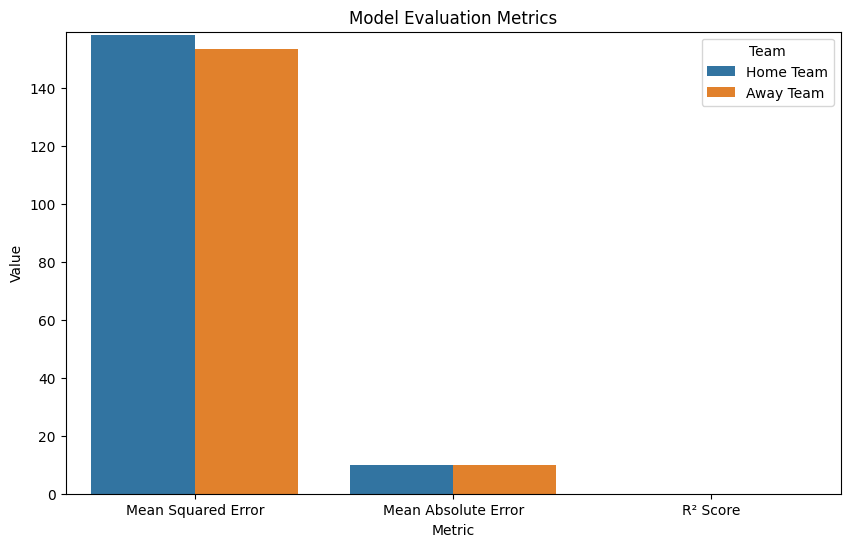

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {
    'Metric': ['Mean Squared Error', 'Mean Absolute Error', 'R² Score'],
    'Home Team': [test_home_mse, test_home_mae, test_home_r2],
    'Away Team': [test_away_mse, test_away_mae, test_away_r2]
}

import pandas as pd
metrics_df = pd.DataFrame(metrics)

metrics_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Team', value_name='Value')


plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Team', data=metrics_melted)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.ylim(0, max(metrics_melted['Value']) + 1) 
plt.show()


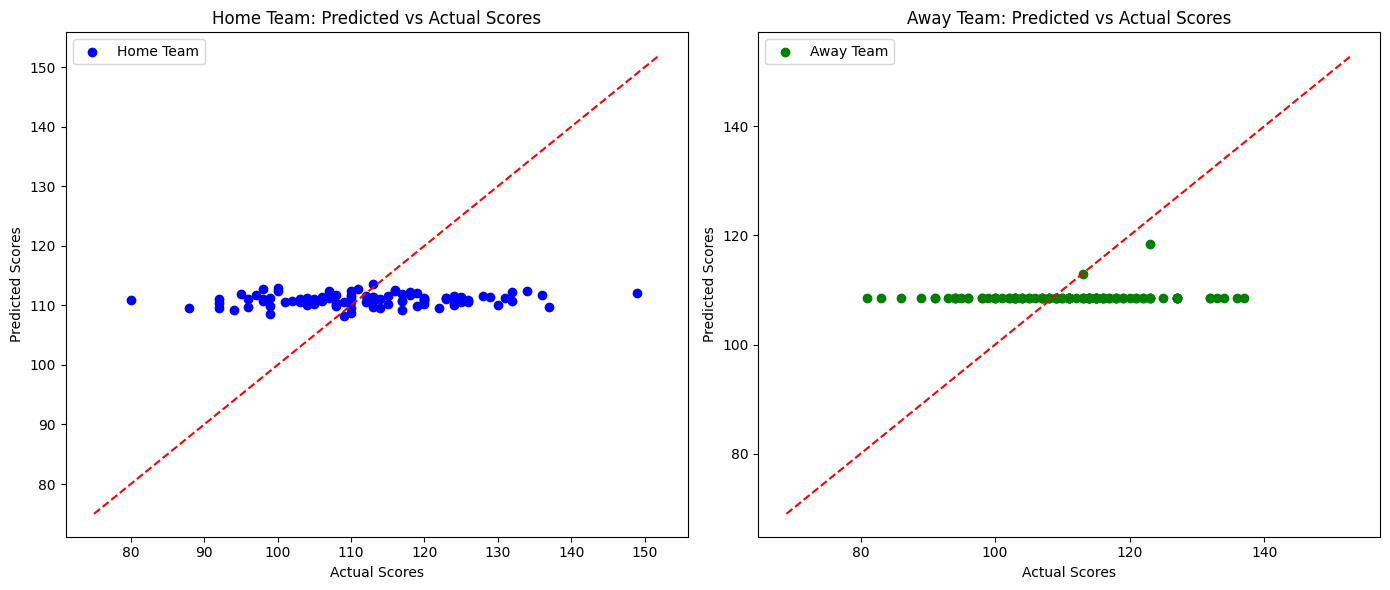

In [21]:
import numpy as np

sample_size = 100  
indices = np.random.choice(range(len(y_test_home_scores)), size=sample_size, replace=False)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_home_scores[indices], y_test_pred_home_scores[indices], color='blue', label='Home Team')
plt.plot([min(y_test_home_scores), max(y_test_home_scores)], [min(y_test_home_scores), max(y_test_home_scores)], color='red', linestyle='--')
plt.title('Home Team: Predicted vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_away_scores[indices], y_test_pred_away_scores[indices], color='green', label='Away Team')
plt.plot([min(y_test_away_scores), max(y_test_away_scores)], [min(y_test_away_scores), max(y_test_away_scores)], color='red', linestyle='--')
plt.title('Away Team: Predicted vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.legend()

plt.tight_layout()
plt.show()
